# Study on the IRIS DataBase

if the package POT is not already installed on ur computer, use "pip install pot"

## Import

In [25]:
import numpy as np
import ot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('BASE_TD_FILO_DEC_IRIS_2020.csv', sep=';', decimal=',')

# Main numerical variables
numerical_cols = df.select_dtypes(include=['number']).columns

# Decile columns
decile_cols = ['DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_MED20', 'DEC_D620', 'DEC_D720', 'DEC_D820', 'DEC_D920']

# Convert from object to float64
df[decile_cols] = df[decile_cols].apply(pd.to_numeric, errors='coerce')

# Remove the 1319 rows with missing deciles
df_clean = df.dropna(subset=decile_cols + ['DEC_MED20']).reset_index(drop=True)

# Support of the deciles 
support = np.arange(1, 10)  # D1 to D9

# Colors used for visualization
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']


Data preview:
        IRIS DEC_PIMP20 DEC_TP6020 DEC_Q120  DEC_MED20 DEC_Q320 DEC_EQ20  \
0  010040101       41,8       32,7    10940    18240.0    24950     0,77   
1  010040102       39,0       41,1     9010    15860.0    23660     0,92   
2  010040201       45,6       29,2    11700    19130.0    27000     0,80   
3  010040202       59,8       14,0    17500    24790.0    33710     0,65   
4  010330102       39,1       30,6    11100    19090.0    29590     0,97   

   DEC_D120  DEC_D220  DEC_D320  ...  DEC_RD20  DEC_S80S2020  DEC_GI20  \
0    6220.0    9630.0   12440.0  ...       5,3           6,8     0,328   
1    4030.0    7750.0   10150.0  ...       7,8           9,7     0,370   
2    6150.0   10030.0   13260.0  ...       5,7           7,6     0,342   
3   10820.0   15850.0   19050.0  ...       4,1           5,5     0,317   
4    4930.0    9220.0   12910.0  ...       8,6          10,7     0,391   

   DEC_PACT20  DEC_PTSA20 DEC_PCHO20 DEC_PBEN20 DEC_PPEN20 DEC_PAUT20  \
0        68

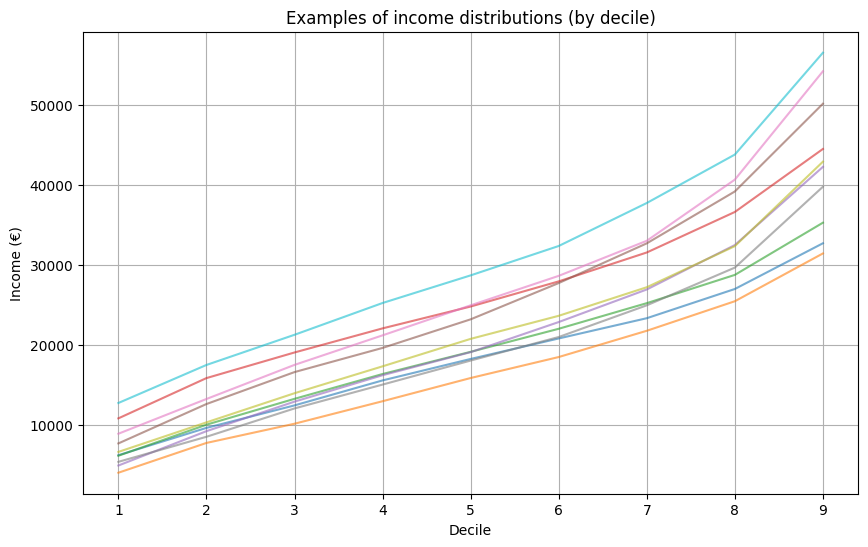

In [26]:
# Overview of the data
print("Data preview:")
print(df_clean.head())

print("\nGeneral information:")
print(df_clean.info())

print("\nDescriptive statistics:")
print(df_clean.describe())

# Plot of few IRIS deciles
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(support, df_clean.loc[i, decile_cols], alpha=0.6)
plt.title("Examples of income distributions (by decile)")
plt.xlabel("Decile")
plt.ylabel("Income (€)")
plt.grid(True)
plt.show()


## Barycenters with Wasserstein

In [28]:
# Parameters
k = 3
n_iter = 20

a = np.ones(len(support)) / len(support)

# Normalization
distributions_raw = df_clean[decile_cols].to_numpy()
distributions = distributions_raw / distributions_raw.sum(axis=1, keepdims=True)
n_distributions = distributions.shape[0]

# Random initial assignment
assignments = np.random.choice(k, size=n_distributions)


for it in range(n_iter):
    # Computation of barycenters
    barycenters = []
    for j in range(k):
        members = distributions[assignments == j]
        if len(members) == 0:
            # Empty cluster: sample a random distribution
            barycenters.append(distributions[np.random.randint(n_distributions)])
        else:
            barycenters.append(np.mean(members, axis=0))  # 1D barycenter = mean

    # Reassignement
    new_assignments = np.zeros(n_distributions, dtype=int)
    for i in range(n_distributions):
        dists = [ot.wasserstein_1d(support, support, distributions[i], bary) for bary in barycenters]
        new_assignments[i] = np.argmin(dists)

    assignments = new_assignments

# Save cluster assignment
df_clean["cluster_wasserstein_1d"] = assignments


Barycenters plot

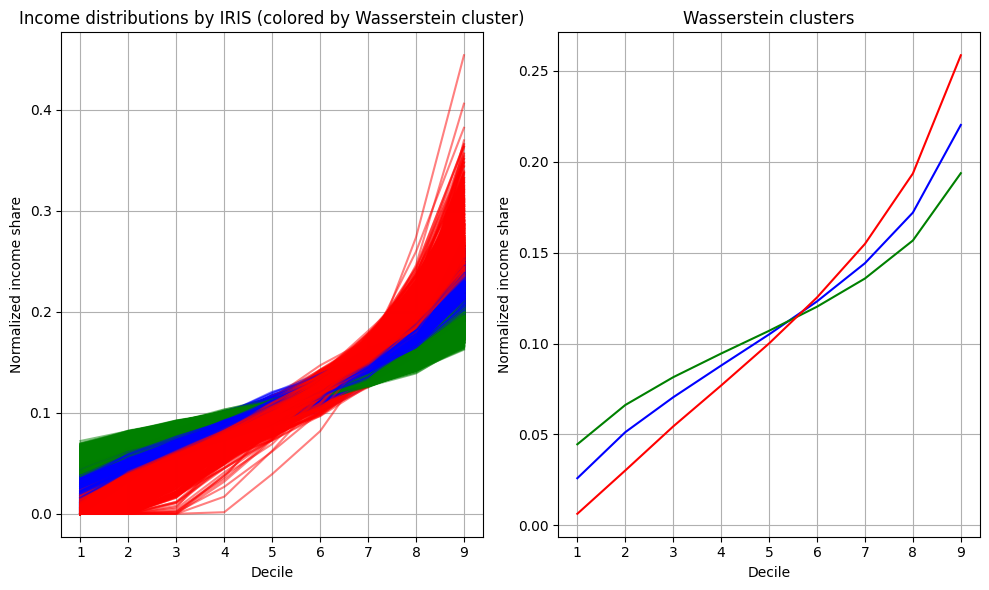

In [32]:
plt.figure(figsize=(10, 6))

# Plot all distributions 
plt.subplot(1, 2, 1)
for i in range(n_distributions):
    cluster = assignments[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)

plt.title("Income distributions by IRIS (colored by Wasserstein cluster)")
plt.xlabel("Decile")
plt.ylabel("Normalized income share")
plt.grid(True)

# Plot Barycenters
plt.subplot(1, 2, 2)
for i in range(len(barycenters)):
    plt.plot(support, barycenters[i], color=colors[i % len(colors)])
plt.title("Wasserstein clusters")
plt.xlabel("Decile")
plt.ylabel("Normalized income share")
plt.grid(True)

plt.tight_layout()
plt.show()

### PCA Projection

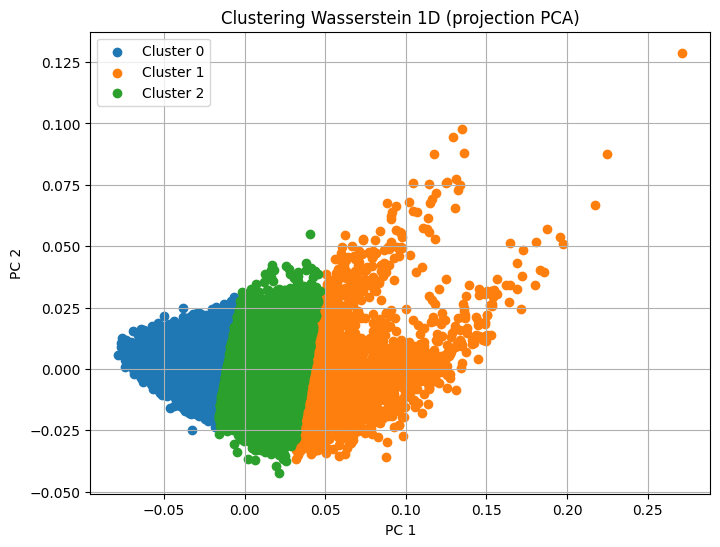

In [ ]:
from sklearn.decomposition import PCA

# PCA pour réduire à 2 dimensions les distributions (quantiles normalisés)
pca = PCA(n_components=2)
proj = pca.fit_transform(distributions)

# Affichage des clusters Wasserstein 1D
plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(proj[assignments == i, 0], proj[assignments == i, 1], label=f'Cluster {i}')
plt.title("Clustering Wasserstein 1D (projection PCA)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


Comparision with a Kmeans on the median

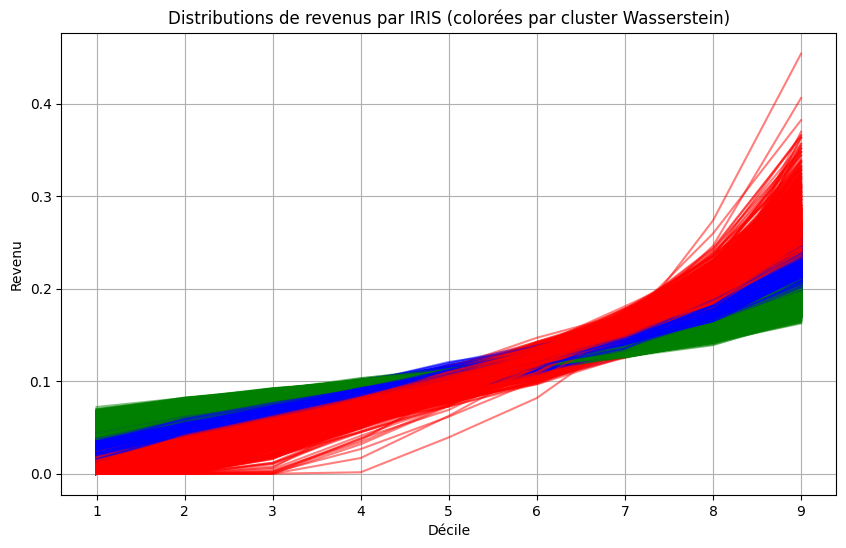

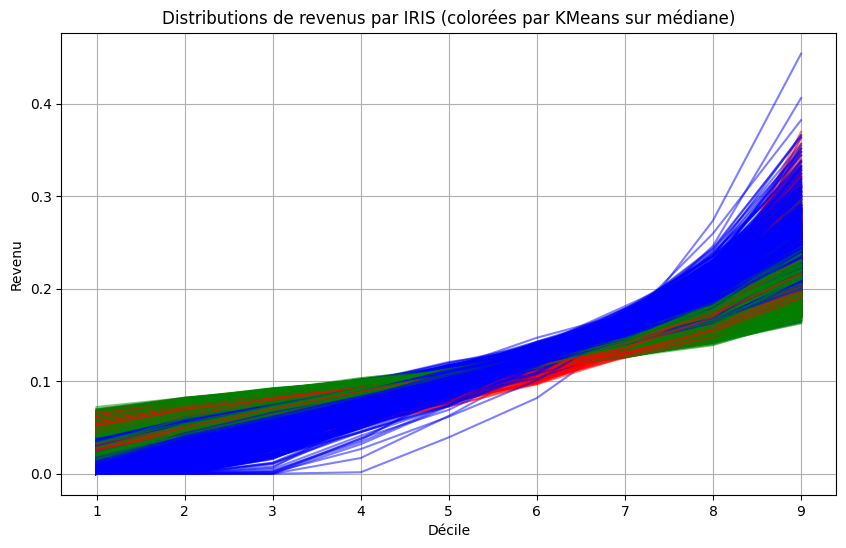

In [29]:
from sklearn.cluster import KMeans

# KMeans sur la médiane (DEC_MED20)
kmeans_median = KMeans(n_clusters=k, n_init="auto", random_state=0)
df_clean["cluster_median"] = kmeans_median.fit_predict(df_clean[["DEC_MED20"]])

# Clustering Wasserstein 1D
plt.figure(figsize=(10, 6))

for i in range(n_distributions):
    cluster = assignments[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)

plt.title("Distributions de revenus par IRIS (colorées par cluster Wasserstein)")
plt.xlabel("Décile")
plt.ylabel("Revenu")
plt.grid(True)
plt.show()

# Clustering médiane
plt.figure(figsize=(10, 6))

for i in range(n_distributions):
    cluster = df_clean['cluster_median'].iloc[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)

plt.title("Distributions de revenus par IRIS (colorées par KMeans sur médiane)")
plt.xlabel("Décile")
plt.ylabel("Revenu")
plt.grid(True)
plt.show()


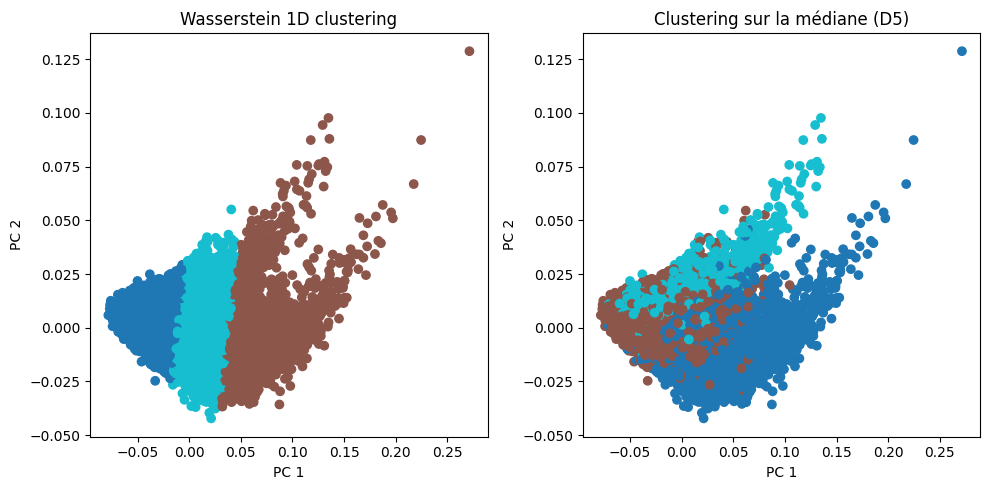

In [12]:
from sklearn.cluster import KMeans

# KMeans sur la médiane (DEC_D520)
kmeans_median = KMeans(n_clusters=k, n_init="auto", random_state=0)
df_clean["cluster_median"] = kmeans_median.fit_predict(df_clean[["DEC_MED20"]])

# Visualisation comparée des deux clusters
plt.figure(figsize=(10, 5))

# Wasserstein
plt.subplot(1, 2, 1)
plt.scatter(proj[:, 0], proj[:, 1], c=df_clean["cluster_wasserstein_1d"], cmap="tab10")
plt.title("Wasserstein 1D clustering")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# Médiane
plt.subplot(1, 2, 2)
plt.scatter(proj[:, 0], proj[:, 1], c=df_clean["cluster_median"], cmap="tab10")
plt.title("Clustering sur la médiane (D5)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

plt.tight_layout()
plt.show()


Cartographie

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Création d’un GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean.longitude, df_clean.latitude),
    crs="EPSG:4326"
)

# Affichage des clusters Wasserstein 1D sur carte
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column="cluster_wasserstein_1d", cmap="Set1", legend=True, ax=ax, markersize=5)
plt.title("Carte des clusters (Wasserstein 1D)")
plt.axis("off")
plt.show()

# Même chose pour clustering médiane
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column="cluster_median", cmap="Set2", legend=True, ax=ax, markersize=5)
plt.title("Carte des clusters (médiane)")
plt.axis("off")
plt.show()


AttributeError: 'DataFrame' object has no attribute 'longitude'